<a href="https://colab.research.google.com/github/AbhilashDatta/LITS/blob/main/LITS_Segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
!pip install --upgrade kornia > /dev/null
!pip install allennlp==1.1.0.rc4 > /dev/null
!pip install --upgrade fastai > /dev/null
import fastai
fastai.__version__

In [4]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [8]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Training Batch 1'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Training Batch 2'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
1,/content/gdrive/MyDrive/Training Batch 1,segmentation-0.nii
3,/content/gdrive/MyDrive/Training Batch 1,segmentation-1.nii
21,/content/gdrive/MyDrive/Training Batch 1,segmentation-10.nii
200,/content/gdrive/MyDrive/Training Batch 2,segmentation-100.nii
202,/content/gdrive/MyDrive/Training Batch 2,segmentation-101.nii
...,...,...
189,/content/gdrive/MyDrive/Training Batch 2,volume-95.nii
191,/content/gdrive/MyDrive/Training Batch 2,volume-96.nii
193,/content/gdrive/MyDrive/Training Batch 2,volume-97.nii
195,/content/gdrive/MyDrive/Training Batch 2,volume-98.nii


In [11]:
# Map CT scan and label 

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask


df_files['mask_dirname'] = df_files['dirname']
# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files

131


,dirname,filename,mask_dirname,mask_filename
0,/content/gdrive/MyDrive/Training Batch 1,volume-0.nii,/content/gdrive/MyDrive/Training Batch 1,segmentation-0.nii
1,/content/gdrive/MyDrive/Training Batch 1,volume-1.nii,/content/gdrive/MyDrive/Training Batch 1,segmentation-1.nii
2,/content/gdrive/MyDrive/Training Batch 1,volume-10.nii,/content/gdrive/MyDrive/Training Batch 1,segmentation-10.nii
3,/content/gdrive/MyDrive/Training Batch 2,volume-100.nii,/content/gdrive/MyDrive/Training Batch 2,segmentation-100.nii
4,/content/gdrive/MyDrive/Training Batch 2,volume-101.nii,/content/gdrive/MyDrive/Training Batch 2,segmentation-101.nii
...,...,...,...,...
126,/content/gdrive/MyDrive/Training Batch 2,volume-95.nii,/content/gdrive/MyDrive/Training Batch 2,segmentation-95.nii
127,/content/gdrive/MyDrive/Training Batch 2,volume-96.nii,/content/gdrive/MyDrive/Training Batch 2,segmentation-96.nii
128,/content/gdrive/MyDrive/Training Batch 2,volume-97.nii,/content/gdrive/MyDrive/Training Batch 2,segmentation-97.nii
129,/content/gdrive/MyDrive/Training Batch 2,volume-98.nii,/content/gdrive/MyDrive/Training Batch 2,segmentation-98.nii


In [12]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [13]:
# Read sample
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct.shape, sample_mask.shape

((512, 512, 75), (512, 512, 75))

In [14]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


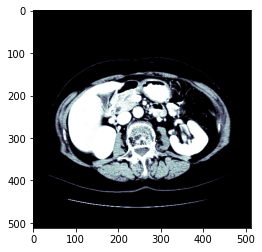

In [49]:
dicom_windows = types.SimpleNamespace(
    liver=(150,30),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [50]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

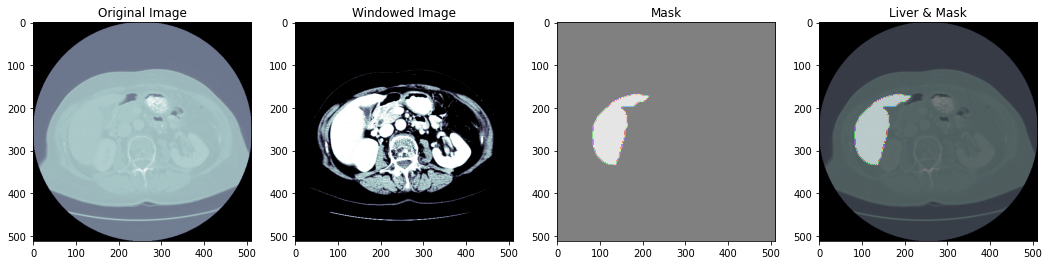

In [51]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

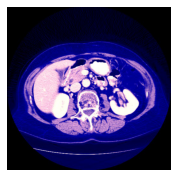

In [52]:
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [28]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    
    path = Path("/content/") 


  0%|          | 0/44 [00:00<?, ?it/s]

# Model Training

In [29]:
batch_size = 16
im_size = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')

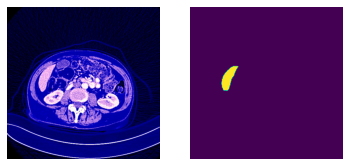

In [41]:
idx=1
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i])

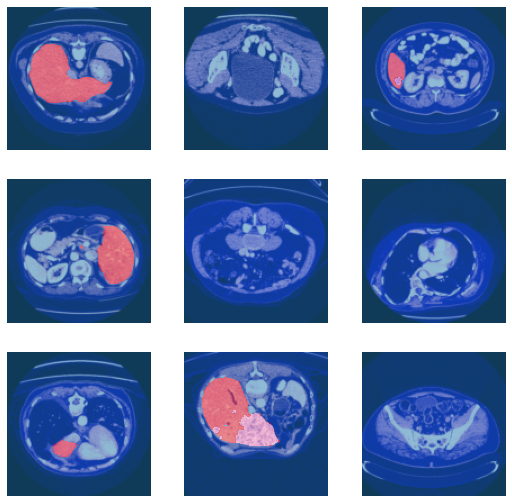

In [33]:
dls = db.dataloaders(path/'train_images',bs = batch_size) #, num_workers=0
dls.show_batch()

In [34]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1)

# Fine-tuning a pretrained model

In [35]:
learn = unet_learner(dls, resnet34, loss_func = CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc]) 

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [37]:
learn.fine_tune(1, wd=0.1, cbs = SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.006457,0.005804,0.939194,0.997904,01:51


Better model found at epoch 0 with valid_loss value: 0.005804440006613731.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.003970,0.003866,0.963418,0.998484,01:56


Better model found at epoch 0 with valid_loss value: 0.0038662152364850044.


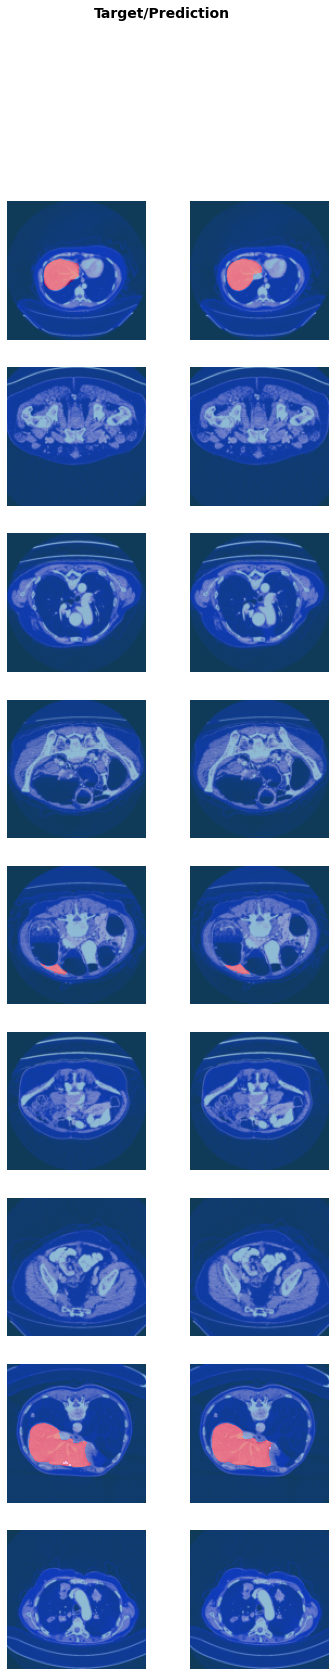

In [53]:
learn.show_results()